In [2]:
%cd "~/pln-brca-xp/notebooks"
%load_ext autoreload
%autoreload 2

/home/xabush/pln-brca-xp/notebooks


In [1]:
from utils_emb import *
from utils import *
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'utils_emb'

In [4]:
st_df = pd.read_csv("/var/www/datasets/embedding_vector_state_and_outcome.csv", index_col="patient_ID")
tamoxifen_studies_v2 = ["GSE12093",  "GSE1379", "GSE17705", "GSE9893"]
st_tamx_df = st_df[st_df["series_id"].isin(tamoxifen_studies_v2)]

In [62]:
X_train, X_test = pd.read_table("/var/www/datasets/embedding-vectors/tamoxifen_group/property_vector_100genes_ge_pln_TRAIN_2021-03-25.csv", index_col="patient_ID"), pd.read_table("/var/www/datasets/embedding-vectors/tamoxifen_group/property_vector_100genes_ge_pln_TEST_2012-03-25.csv", index_col="patient_ID")
X_train_st, X_test_st = st_tamx_df.loc[X_train.index,:], st_tamx_df.loc[X_test.index,:]

In [6]:
pam_subtypes_df = X_train_st[["pam_coincide", "posOutcome"]]
pam_subtypes_df.columns = ["pam", "posOutcome"]
pam_subtypes_df

,pam,posOutcome
patient_ID,,
249600,Her2,0
441891,LumB,1
249532,LumA,0
22476,LumA,1
305173,LumB,1
...,...,...
22507,LumA,1
249669,Normal,1
305255,LumB,1


In [7]:
X_train_kpca, X_test_kpca, kpca = do_emb(X_train, X_test, ker=tanimoto_v2)
X_train_kpca, X_test_kpca = pd.DataFrame(X_train_kpca, index=X_train.index), pd.DataFrame(X_test_kpca, index=X_test.index)
X_train_kpca_df, X_test_kpca_df = pd.merge(X_train_kpca, st_tamx_df.loc[:,["posOutcome", "series_id"]], left_index=True, right_index=True), pd.merge(X_test_kpca, st_tamx_df.loc[:,["posOutcome", "series_id"]], left_index=True, right_index=True)

2.5816814192276797e-33
0.001522027675451697


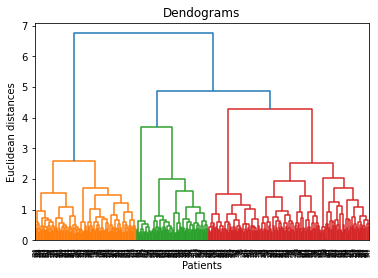

In [8]:
n_comps = range(0, 19)
import scipy.cluster.hierarchy as sch
dendrogram_1 = sch.dendrogram(sch.linkage(X_train_kpca.loc[:,n_comps], method = 'ward'))
plt.title('Dendograms')
plt.xlabel('Patients')
plt.ylabel('Euclidean distances')
plt.show()

In [9]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_train_kpca.loc[:,n_comps])

In [34]:
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=5)
y_hc_2 = kmedoids.fit_predict(X_train_kpca.loc[:,n_comps])

<AxesSubplot:title={'center':'Series'}, xlabel='0', ylabel='1'>

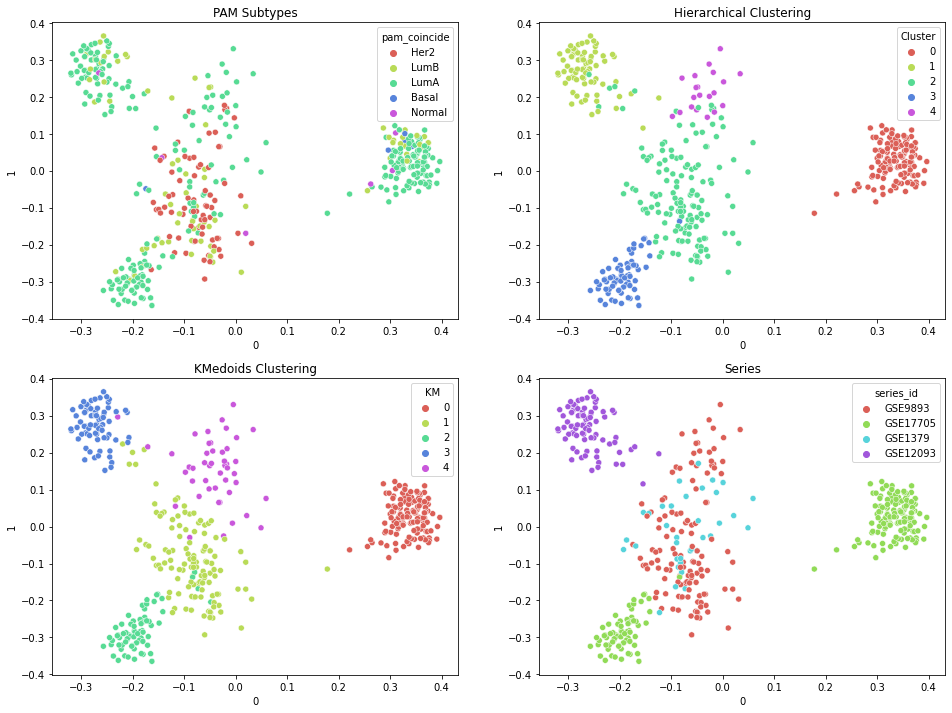

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
y_hc_df = pd.Series(y_hc, name="Cluster", index=X_train_kpca.index)
X_train_kpca_hc_df = X_train_kpca_df.join(y_hc_df)
y_hc_2_df = pd.Series(y_hc_2, name="KM", index=X_train_kpca.index)
X_train_kpca_hc_2_df = X_train_kpca_df.join(y_hc_2_df)
X_train_kpca_hc_df = X_train_kpca_hc_df.join(st_tamx_df["pam_coincide"])
ax[0, 0].set_title("PAM Subtypes")
ax[0, 1].set_title("Hierarchical Clustering")
ax[1, 0].set_title("KMedoids Clustering")
ax[1, 1].set_title("Series")
sns.scatterplot(data=X_train_kpca_hc_df, x=0, y=1, hue="pam_coincide", palette=sns.hls_palette(5), ax=ax[0, 0])
sns.scatterplot(data=X_train_kpca_hc_df, x=0, y=1, hue="Cluster", palette=sns.hls_palette(5), ax=ax[0, 1])
sns.scatterplot(data=X_train_kpca_hc_2_df, x=0, y=1, hue="KM", palette=sns.hls_palette(5), ax=ax[1, 0])
sns.scatterplot(data=X_train_kpca_hc_df, x=0, y=1, hue="series_id", palette=sns.hls_palette(4), ax=ax[1, 1])

In [17]:
X_train_kpca_hc_df

,0,1,2,3,4,5,6,7,8,9,...,442,443,444,445,446,447,posOutcome,series_id,Cluster,pam_coincide
patient_ID,,,,,,,,,,,,,,,,,,,,,
249600,-0.090228,0.160182,0.192914,-0.318184,0.146528,-0.081239,0.115924,0.393187,-0.020168,0.161349,...,-0.018335,0.006693,-0.007062,0.006996,0.000335,-0.075654,0,GSE9893,2,Her2
441891,0.356243,0.024978,-0.032721,0.004253,-0.200440,-0.210023,0.123023,0.045989,0.030498,-0.022656,...,0.004848,-0.005198,-0.003651,-0.000758,0.002144,-0.000011,1,GSE17705,0,LumB
249532,-0.029772,0.144783,0.390355,0.080508,0.124430,-0.139503,-0.224427,0.067409,-0.070215,0.072815,...,0.034648,0.002552,0.014319,0.026173,-0.012422,0.000125,0,GSE9893,4,LumA
22476,-0.062917,-0.065810,0.040692,-0.146223,-0.005762,-0.034477,-0.033152,-0.079181,0.129202,-0.067364,...,0.000135,0.012193,-0.002130,0.002512,0.004025,0.000038,1,GSE1379,2,LumA
305173,-0.229091,0.296479,0.148680,-0.069066,-0.038814,0.049280,0.127086,-0.121658,0.076337,0.034167,...,-0.015507,0.017568,-0.020436,-0.000385,0.004066,0.000503,1,GSE12093,1,LumB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22507,-0.047384,0.015659,-0.065215,-0.048073,0.012446,0.035097,-0.231062,0.081154,0.019284,0.051405,...,-0.017460,-0.005471,-0.002211,0.013541,0.001426,0.000004,1,GSE1379,2,LumA
249669,0.019627,-0.169198,0.005429,-0.172887,0.070840,0.082542,-0.111602,0.031399,0.099290,-0.180168,...,-0.005382,0.001051,0.013390,0.012816,0.000857,-0.000217,1,GSE9893,2,Normal
305255,-0.282043,0.275100,-0.144924,0.009200,-0.270774,0.125428,0.006032,-0.003680,-0.070465,0.033842,...,-0.029604,0.021485,-0.000396,-0.002542,-0.004102,-0.000073,1,GSE12093,1,LumB


In [36]:
pam_subtypes_df["hi_cluster"] = y_hc
pam_subtypes_df["md_cluster"] = y_hc_2

<ipython-input-36-47f74cd4949d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pam_subtypes_df["hi_cluster"] = y_hc
<ipython-input-36-47f74cd4949d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pam_subtypes_df["md_cluster"] = y_hc_2


In [37]:
from sklearn.preprocessing import LabelEncoder
lbe = LabelEncoder()
X_lbe = lbe.fit_transform(pam_subtypes_df["pam"])
pam_subtypes_df["pam"] = X_lbe
pam_subtypes_df

<ipython-input-37-83b1a5b4fc8c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pam_subtypes_df["pam"] = X_lbe


,pam,posOutcome,hi_cluster,md_cluster
patient_ID,,,,
249600,1,0,2,4
441891,3,1,0,0
249532,2,0,4,4
22476,2,1,2,1
305173,3,1,1,4
...,...,...,...,...
22507,2,1,2,1
249669,4,1,2,1
305255,3,1,1,3


In [38]:
from sklearn.feature_selection import mutual_info_classif
feats, outcome = pam_subtypes_df.drop(["posOutcome"], axis=1), pam_subtypes_df["posOutcome"]

In [39]:
mi = mutual_info_classif(feats, outcome, discrete_features=True)
print(mi)

[0.00252529 0.03638991 0.08745958]


In [41]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

feats_ohe = ohe.fit_transform(feats).toarray()

In [42]:
feats_ohe_df = pd.DataFrame(feats_ohe, index=feats.index, columns=["pam_0", "pam_1", "pam_2", "pam_3", "pam_4",
                "hi_0", "hi_1", "hi_2", "hi_3", "hi_4", "md_0", "md_1", "md_2", "md_3", "md_4"])
feats_ohe_df = feats_ohe_df.join(outcome)
feats_ohe_df

,pam_0,pam_1,pam_2,pam_3,pam_4,hi_0,hi_1,hi_2,hi_3,hi_4,md_0,md_1,md_2,md_3,md_4,posOutcome
patient_ID,,,,,,,,,,,,,,,,
249600,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
441891,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
249532,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
22476,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
305173,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22507,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
249669,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
305255,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [46]:
mi = mutual_info_classif(feats_ohe, outcome, discrete_features=True)
print(mi)

[1.38150469e-04 5.35810102e-05 1.15797113e-03 1.88984410e-03
 3.85494152e-04 8.85668885e-06 1.31855726e-02 4.55807072e-03
 4.67555944e-03 1.90984579e-02 3.87303246e-07 4.38610845e-03
 5.69950815e-03 1.16971160e-02 7.95592699e-02]


In [43]:
from xgboost import XGBClassifier

clf = XGBClassifier()

clf.fit(feats_ohe_df.drop(["posOutcome"], axis=1), feats_ohe_df["posOutcome"])

/home/xabush/venv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:30:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

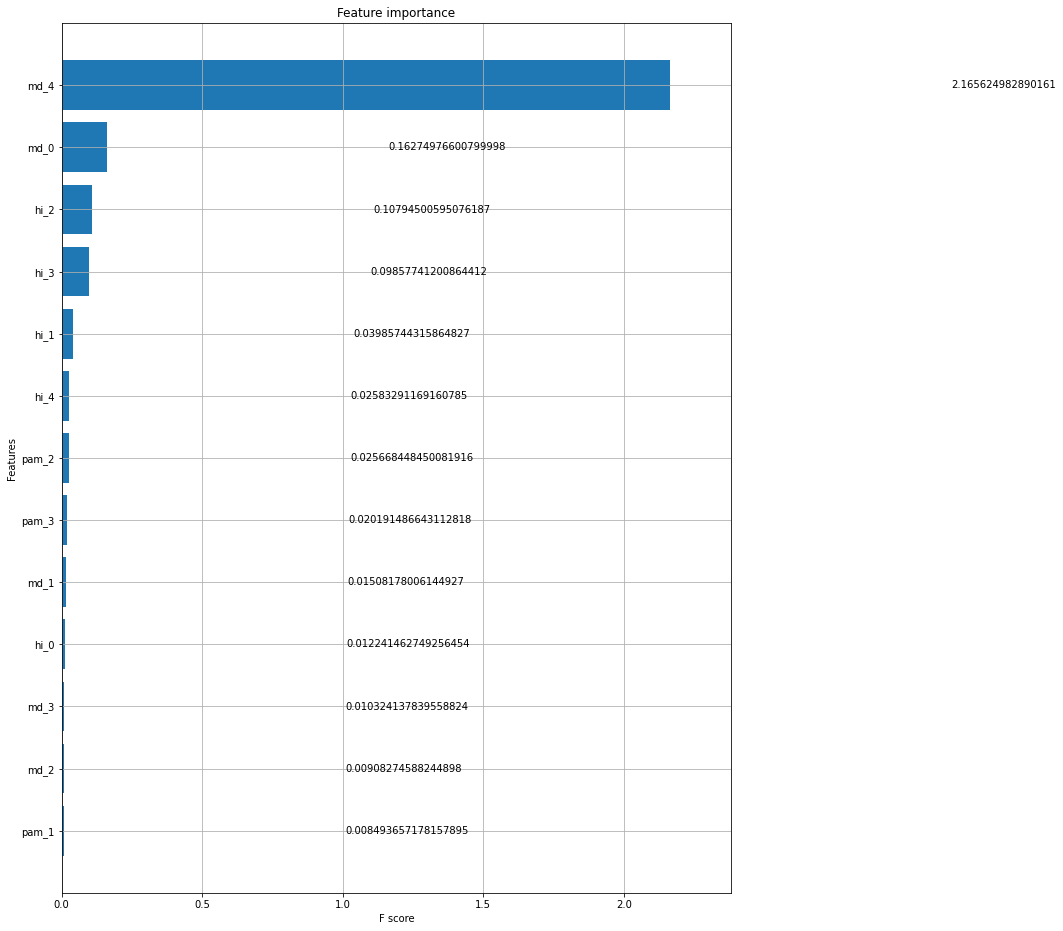

In [44]:

from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12, 16))
plot_importance(clf, max_num_features=50, height=0.8, ax=ax, importance_type='gain')
plt.show()

In [45]:
clf.feature_importances_

array([0.        , 0.00314385, 0.00950095, 0.0074737 , 0.        ,
       0.00453107, 0.01475288, 0.0399549 , 0.03648756, 0.00956183,
       0.0602404 , 0.00558239, 0.0033619 , 0.00382139, 0.80158716],
      dtype=float32)

In [52]:
from sklearn.metrics.pairwise import  pairwise_kernels
outcome_st = X_train_st["posOutcome"]
tan_k = pairwise_kernels(X_train, X_train, metric=tanimoto)

In [77]:
tan_k

array([[1.        , 0.21642977, 0.40394753, ..., 0.29709219, 0.1719648 ,
        0.41140809],
       [0.21642977, 1.        , 0.23156403, ..., 0.22205345, 0.25900117,
        0.22315888],
       [0.40394753, 0.23156403, 1.        , ..., 0.27331431, 0.16278318,
        0.51363485],
       ...,
       [0.29709219, 0.22205345, 0.27331431, ..., 1.        , 0.1454281 ,
        0.28223982],
       [0.1719648 , 0.25900117, 0.16278318, ..., 0.1454281 , 1.        ,
        0.14483321],
       [0.41140809, 0.22315888, 0.51363485, ..., 0.28223982, 0.14483321,
        1.        ]])

In [78]:
from sklearn import svm

svc = svm.SVC(kernel="precomputed", C=1.0, probability=True, class_weight={1: 3.0})
cv_res = cross_validate(clf, tan_k, outcome_st, scoring=scoring, cv=st_cv, n_jobs=-1)
cv_res_df = get_scores(cv_res)
cv_res_df

,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.725711,0.533333,0.721083,0.918089,0.844726,0.833726,0.533333,0.217313


In [81]:
svc = svc.fit(tan_k, outcome_st)

In [82]:
outcome_st_test = X_test_st["posOutcome"]
tan_k_test = pairwise_kernels(X_test, X_train, metric=tanimoto)

In [83]:
test_scores = calc_scores(svc, tan_k_test, outcome_st_test)
test_scores




,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.567109,0.176471,0.6,0.957746,0.764045,0.737089,0.176471,0.240948
